## Stock Price Prediction Using ML

In [39]:
"""Import Packages"""

import datetime as dt
import pandas as pd
import numpy as np
import pandas_datareader as pdr
from typing import Any
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

### Fetching ticker data

In [40]:
class DataStock:
    def __init__(self, ticker: str, start: dt.datetime, end: dt.datetime )-> None:
        self.ticker: str = ticker
        self.start: dt.datetime = start
        self.end: dt.datetime = end

    def data_stock(self) -> pd.DataFrame:
         return pdr.get_data_stooq(self.ticker, self.start, self.end)[: : -1]
    
ticker = 'GOOG'
ticker_data: DataStock = DataStock(ticker, dt.datetime(2018, 1, 1), dt.datetime(2023, 4, 11))
dataframe: pd.DataFrame = ticker_data.data_stock()
dataframe.head()

,Open,High,Low,Close,Volume
Date,,,,,
2018-01-02,52.4170,53.3470,52.2615,53.2450,24728020
2018-01-03,53.2155,54.3145,53.1605,54.1240,28597660
2018-01-04,54.4000,54.6785,54.2000,54.3200,20074800
2018-01-05,54.7000,55.2125,54.6000,55.1115,25578420
2018-01-08,55.1115,55.5635,55.0810,55.3470,20935380


In [41]:
class Plotter:
    def __init__(self, title: str, xlabel: str, ylabel: str, legend: str) -> None:
        plt.style.use('fivethirtyeight')
        plt.style.use('dark_background')
        
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.legend = legend
        
    def plot_before_training(self, x: pd.DataFrame) -> None:
        plt.figure(figsize=(20, 10))
        plt.title(self.title)
        plt.plot(x, color='b')
        plt.xlabel(self.xlabel, fontsize=15)
        plt.ylabel(self.ylabel, fontsize=15)
        plt.legend([self.legend], loc='upper left')
        plt.show()
    
    def plot_after_training(self, train_close, valid_close, pred_close) -> None:
        plt.figure(figsize=(20, 10))
        plt.title(self.title)
        plt.plot(train_close, color='b', label='Training Data')
        plt.plot(valid_close, color='y', label='Validation Data')
        plt.plot(pred_close, color='r', label='Predicted Data')
        plt.xlabel(self.xlabel, fontsize=15)
        plt.ylabel(self.ylabel, fontsize=15)
        plt.legend(loc='upper left')
        plt.show()


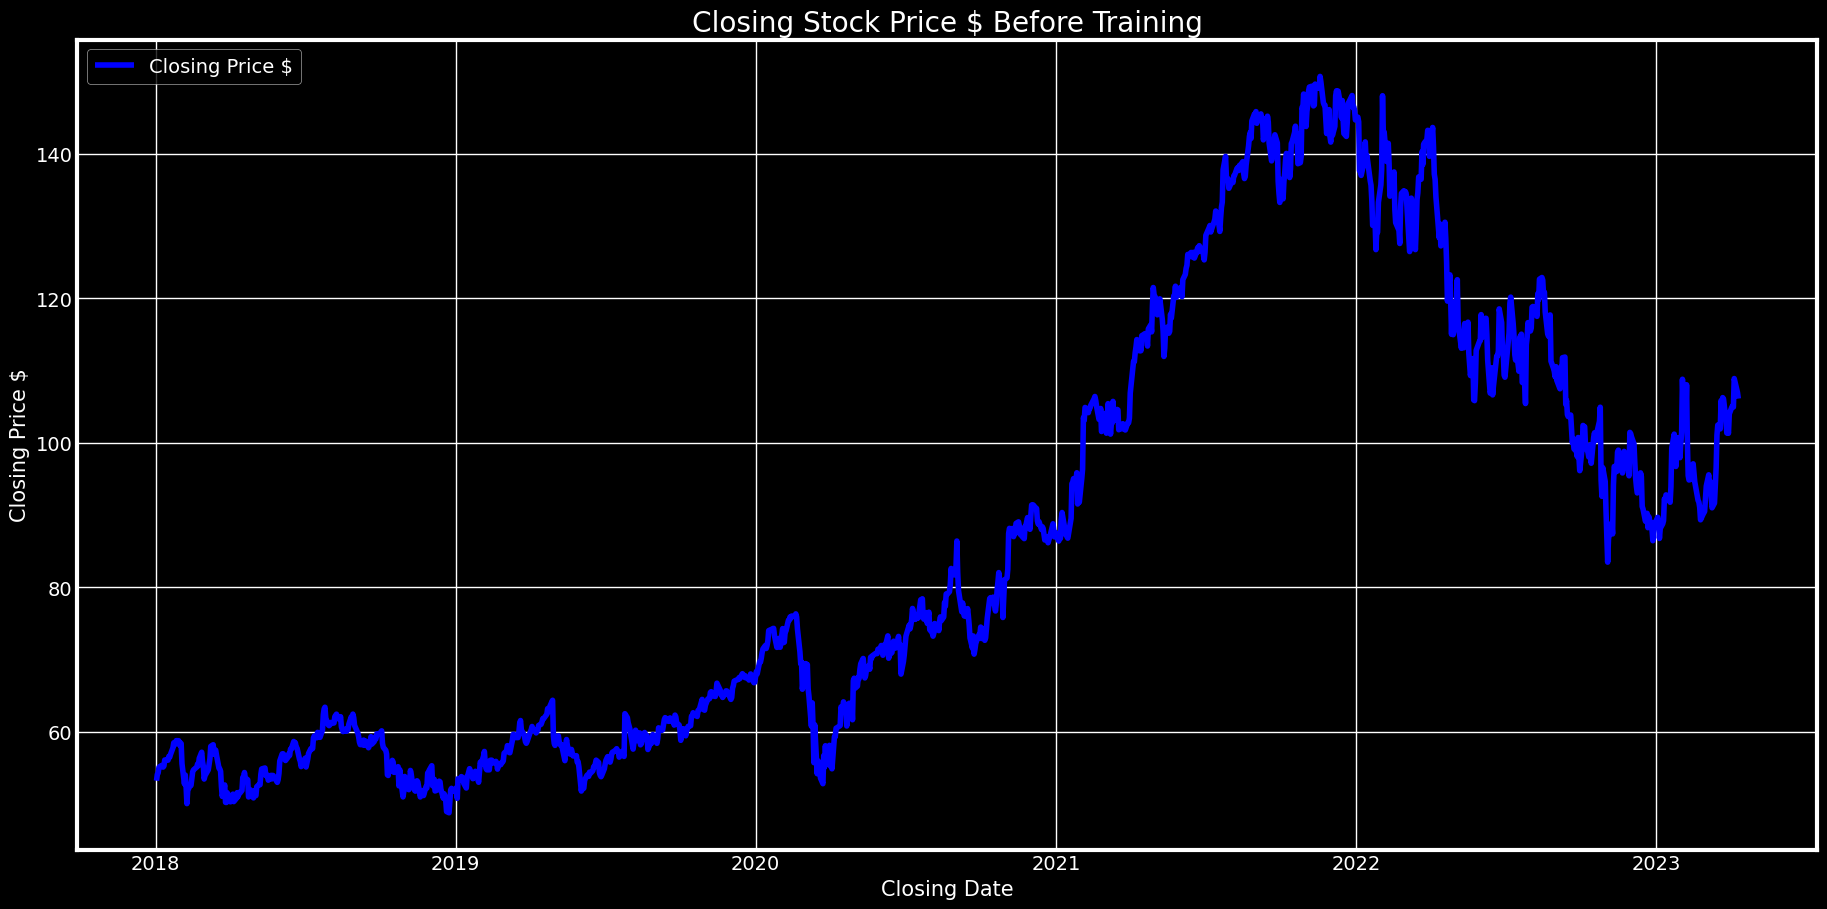

In [42]:
"""Plotting the closing price vs price"""
plotter_before_training: Plotter = Plotter(title='Closing Stock Price $ Before Training', 
                                           xlabel='Closing Date', 
                                           ylabel='Closing Price $', 
                                           legend='Closing Price $'
                                           )
plotter_before_training.plot_before_training(dataframe['Close'])

 

### Preprocessing the Data

In [43]:
"""Selecting the closing price"""
dataset: np.ndarray[float, Any] = dataframe.filter(['Close']).values
dataset[0], dataset.shape, type(dataset)

(array([53.245]), (1327, 1), numpy.ndarray)

In [44]:
# Splitting the dataset the to 80% training & 20% testing
data_training_length: int = np.ceil(len(dataset) * 0.8).astype(int)  

data_training_length

1062

In [45]:
# Scaling the data
scaler = MinMaxScaler(feature_range=(0, 1))

scaled_data: np.ndarray[float, Any] = scaler.fit_transform(dataset)
scaled_data[0], len(scaled_data), type(scaled_data)

(array([0.0435141]), 1327, numpy.ndarray)

### Creating Training Dataset

In [46]:
# Splitting the scaled_data into x_train and y_train
train_data: np.ndarray[float, Any] = scaled_data[0: data_training_length, :]
print(f'{data_training_length = }, {train_data[0] = }')

#split the data
x_train: np.ndarray[float, Any] = [] # input
y_train: np.ndarray[float, Any]= [] # Output

for idx in range(60, len(train_data)):
    x_train.append(train_data[idx - 60: idx, 0])
    y_train.append(train_data[idx, 0])

x_train = np.array(x_train) 
y_train = np.array(y_train)

# Reshaping the x_train fro ma 2D -> 3D array to use with LSTM
x_train = x_train[:, :, np.newaxis]
x_train[0][0], x_train.shape, type(x_train) 

data_training_length = 1062, train_data[0] = array([0.0435141])


(array([0.0435141]), (1002, 60, 1), numpy.ndarray)

### Training The Model

In [47]:
"""Training the model using:
    Sequential model with: 
        LSTM with 50 nodes
        LSTM with 50 nodes
        Dense layer 1
        Dense layer 2: Output layer
"""
model: Sequential = Sequential ([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25),
    Dense(1),
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=1, epochs=2)
model.summary()

Epoch 1/2
1002/1002 [==============================] - 18s 14ms/step - loss: 0.0025
Epoch 2/2
1002/1002 [==============================] - 12s 12ms/step - loss: 0.0017
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 60, 50)            10400     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trainable params: 0
_________________________________________________________________


### Testing Dataset

In [48]:
# Creating Testing dataset
test_data: np.ndarray[float, Any] = scaled_data[data_training_length - 60:, :]
x_test: np.ndarray[float, Any] = np.array([test_data[i - 60: i, 0] for i in range(60, len(test_data))])
y_test: np.ndarray[float, Any] = dataset[data_training_length:, :]

# Reshaping from 2D to 3D for the model
# x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))
x_test = x_test[:, :, np.newaxis]

print(f'{test_data[0] = }, {test_data.shape = }, {type(test_data) = }')
print(f'{x_test[0][0] = }, {x_test.shape = }, {type(x_test) = }')
print(f'{y_test[0][0] = }, {y_test.shape = }, {type(y_test) = }')

test_data[0] = array([0.96499441]), test_data.shape = (325, 1), type(test_data) = <class 'numpy.ndarray'>
x_test[0][0] = array([0.96499441]), x_test.shape = (265, 60, 1), type(x_test) = <class 'numpy.ndarray'>
y_test[0][0] = 140.278, y_test.shape = (265, 1), type(y_test) = <class 'numpy.ndarray'>


### Model Prediction

In [49]:
# Model predicted values
predictions: np.ndarray[float, Any] = model.predict(x_test)
print(f'Unscaled: {predictions[0] = }')

# Model prediction unscaled
predictions = scaler.inverse_transform(predictions) 
print(f'Predictions After un-scaling: {predictions[0] = }')

# Evaluation with RMSE: Root Mean Squared Error
# RMSE = 0 => Model is exact
# The smaller the RMSE the Better
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
print(f'RMSE: {rmse:.2f}')

9/9 [==============================] - 1s 13ms/step
Unscaled: predictions[0] = array([0.7936042], dtype=float32)
Predictions After un-scaling: predictions[0] = array([129.67769], dtype=float32)
RMSE: 0.94


### Plotting the train, validation, and prediction

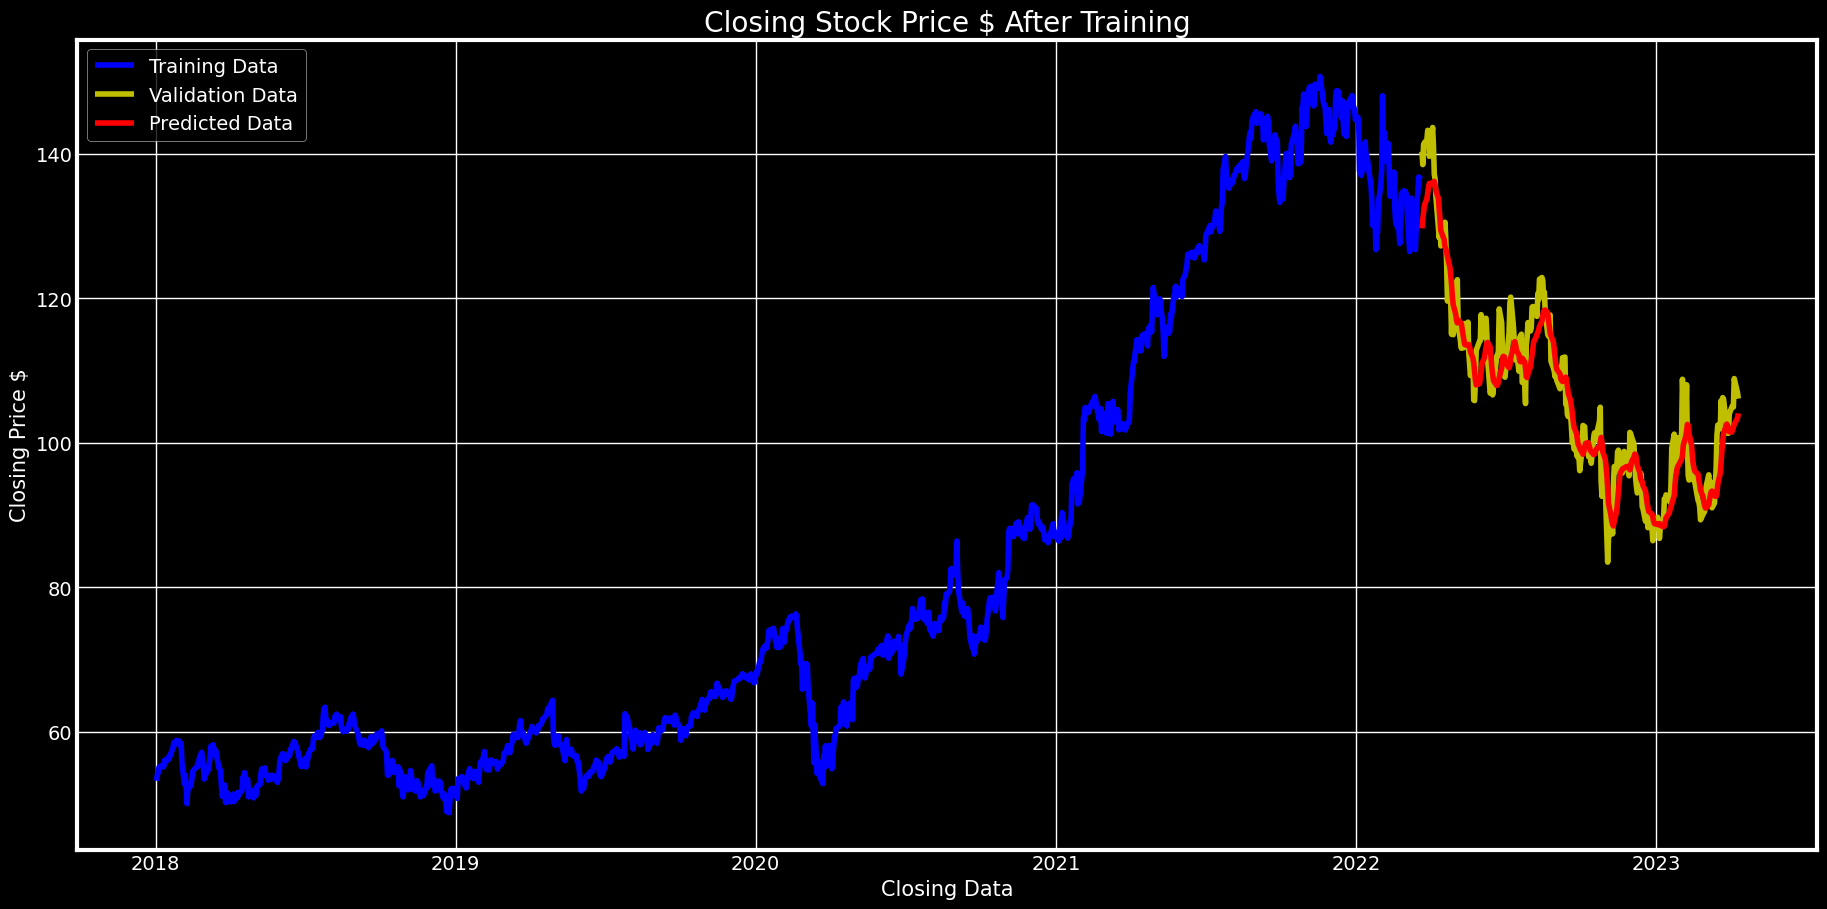

In [50]:
# Plotting the data
# slicing from 0 to the length 80%
train: pd.DataFrame = dataframe[: data_training_length]
# Validation data is the rest 20%
valid: pd.DataFrame = dataframe[data_training_length:].copy()
valid['Predictions'] = predictions
plotter_after_training: Plotter = Plotter(
    title='Closing Stock Price $ After Training', 
    xlabel='Closing Data', 
    ylabel='Closing Price $', 
    legend='Closing Price $'
    )
    
# Plot the data with custom formatting
plotter_after_training.plot_after_training(
    train['Close'], 
    valid['Close'], 
    valid['Predictions']
    )

## Testing the model on 90 last days 

### Preprocessing the data

In [51]:
# new_df: pd.DataFrame = apple_quote.data_stock()['Close']
new_df: pd.DataFrame = dataframe['Close']

# Get the last 90 days and convert to an array
last_90_days: np.ndarray[float, Any] = new_df[-90:].values
# print(f'\n{last_90_days[0] = }\n{last_60_days.shape = }')

# Reshaping the data
last_90_days: np.ndarray[float, Any] = last_90_days[:, np.newaxis]

# Scaling the data
last_90_days_scaled: np.ndarray[float, Any] = scaler.transform(last_90_days)

# Create an empty list
X_test: np.ndarray[float, Any] = np.array([last_90_days_scaled])

# Reshape 2D -> 3D for the LSTM
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
X_test.shape, X_test[0][0] 

((1, 90, 1), array([0.51658521]))

In [52]:
# Get the predicted price
predict_price: np.ndarray[float, Any] = model.predict(X_test)
print(f'Before un-scaling:]\n{predict_price[0] = }')

# Undo the scaling
predict_price = scaler.inverse_transform(predict_price)
print(f'After un-scaling:]\n{predict_price[0] = }')

1/1 [==============================] - 0s 388ms/step
Before un-scaling:]
predict_price[0] = array([0.54616475], dtype=float32)
After un-scaling:]
predict_price[0] = array([104.464096], dtype=float32)


### Testing the Model

In [53]:
# Testing the model
# one_day_dataframe: DataStock = DataStock(ticker, dt.datetime(2023, 4, 13), dt.datetime(2023, 4, 13))
# one_day_data: pd.DataFrame = one_day_dataframe.data_stock()['Close']
real_price = dataset[-1]

# Compare
print(f'{predict_price[0][0] = } : ')
print(f'{real_price[0]= }')

print(f'Model Accurate at {(predict_price[0][0] / real_price[0]) * 100:.2f}%')

predict_price[0][0] = 104.464096 : 
real_price[0]= 106.12
Model Accurate at 98.44%
